# Weather Time Series Strategy Notebook


## Our goals:
- Our strategy model can take 24h weather conditions prediction as a parameters to the car simulation.
- Adjust strategies dynamically based on high-risk conditions (e.g., unexpected cloud cover).
- Optimise Energy Consumption: Knowing the hours of sunshine and solar irradiation helps us manage our energy reserves efficiently.
- Enhance Vehicle Design: Understanding temperature fluctuations allows for designing better cooling systems and ensures the solar panels' efficiency isn't compromised.

### TODO:

- Data Exploration and Preprocessing
  - Visualize correlation and distributions of features over time(daily/hourly)

- update csv utc, date and time

- Scenario Analysis for Weather Conditions
  - Analyze features variance 
  - Define weather scenarios (e.g., clear skies, cloudy, rainy, windy) for risk management.

- Split data to train and test

- Create a prediction model (probably LSTM) for a 24h race (approx. 16-22 september 2026)
- Export the 24h hour predicted model distribution as a paramter to our simulator

## Data collection method
By using solcast API, we managed to collect weather and irradiance data from the circuit zolder route location, the data collected in intervals of 5 minutes and using UTC time format.

![Architecture](media/Architecture.png)

### The chosen features:
1. GHI - "Global Horizontal Irradiance" refers to the total solar radiation received per unit area on a horizontal surface, which helps estimate how much energy is available from all incoming solar radiation, including diffuse sunlight, which can affect the car even when it's not directly facing the sun. `(W/m²)`  
2. DNI - "Direct normal irradiance" represents the quantity of radiation received per unit area on a surface perpendicular to the sun. `(W/m²)`
3. cloud_opacity - Indicates how much sunlight is blocked by clouds. `(%)`
4. Air_temp - Calculated 2m above ground level, Affects solar car efficiency, battery performance and cooling needs. `Celsius (°C)`
5. Wind Speed (10m) - Relevant for aerodynamic drag and car speed optimization. `Meters per second (m/s)`
6. Wind direction (10m)  - See #5. `Degrees (°)`
7. Clearsky_DNI -  additional optimal scenario data. `(W/m²)`
8. Clearsky_GHI - See #7. `(W/m²)`
9. Percipitable_water - Percipitable water can absorb incoming solar radiation at the atmosphere. `Millimeters (mm)`
10. Percipitation_rate - Affects the chance of rain, and indicates the rate of change to #9.` Millimeters per hour (mm/h)`


In [1]:
# notebook imports
import pandas as pd
from datetime import datetime
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# Initialize an empty list to store DataFrames
dfs = []

# Loop through the years and read the CSV files
for i in range(2014, 2025):
    df_temp = pd.read_csv(f'Data/{i}/{i}.csv')
    df_temp = df_temp.drop(columns=['period'])
    dfs.append(df_temp)

# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91872 entries, 0 to 91871
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            91872 non-null  int64  
 1   clearsky_dni        91872 non-null  int64  
 2   clearsky_ghi        91872 non-null  int64  
 3   cloud_opacity       91872 non-null  float64
 4   dni                 91872 non-null  int64  
 5   ghi                 91872 non-null  int64  
 6   precipitable_water  91872 non-null  float64
 7   precipitation_rate  91872 non-null  float64
 8   wind_direction_10m  91872 non-null  int64  
 9   wind_speed_10m      91872 non-null  float64
 10  period_end          91872 non-null  object 
dtypes: float64(4), int64(6), object(1)
memory usage: 7.7+ MB


### As we can see, there is no empty cells in our dataset

In [3]:
df.describe()

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m
count,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000
mean,15.170367,305.275688,191.257032,31.197032,135.792091,132.856616,22.625328,0.098785,187.789141,3.227190
std,4.486312,343.095779,240.391061,31.982306,262.328472,191.354002,6.828265,0.362082,84.570232,1.619955
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.400000,0.000000,124.000000,2.000000
50%,15.000000,8.000000,7.000000,23.100000,0.000000,3.000000,21.600000,0.000000,206.000000,2.900000
75%,18.000000,684.000000,418.000000,58.400000,79.000000,221.000000,27.000000,0.000000,243.000000,4.100000
max,34.000000,910.000000,730.000000,97.000000,910.000000,729.000000,50.000000,6.900000,360.000000,11.300000


In [4]:
df.sample(5)

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m,period_end
51315,11,0,0,0.0,0,0,14.3,0.0,50,1.7,2020-09-10T04:20:00+00:00
51078,19,707,456,66.1,0,155,38.9,0.0,243,4.3,2020-09-09T08:35:00+00:00
51347,14,642,247,0.0,642,247,12.5,0.0,68,1.6,2020-09-10T07:00:00+00:00
50717,13,0,0,20.3,0,0,31.5,0.0,228,3.4,2020-09-08T02:30:00+00:00
19487,24,376,210,41.3,0,123,33.2,0.0,236,5.7,2016-09-15T16:00:00+00:00


 Some conversion (UTC to local time) is needed..

In [5]:
# Converting UTC to the circuit zolder local time
target_timezone = pytz.timezone('Europe/Brussels')

def convert_to_local_time(utc_time_str):
    utc_time = datetime.fromisoformat(utc_time_str)  
    local_time = utc_time.astimezone(target_timezone)
    return local_time

df['local_time'] = df['period_end'].apply(convert_to_local_time)
df = df.drop(columns=['period_end'])

In [6]:
# Convert 'local_time' to datetime format
df['local_time'] = pd.to_datetime(df['local_time'])

# Extracting the date and time from 'local_time'
df['date'] = df['local_time'].dt.date
df['time'] = df['local_time'].dt.time

# Dropping the original 'local_time' column
df = df.drop(columns=['local_time'])

In [7]:
df.value_counts('time')

time
22:35:00    319
22:30:00    319
22:25:00    319
22:20:00    319
22:15:00    319
           ... 
00:20:00    319
00:15:00    319
00:10:00    319
00:05:00    319
00:00:00    319
Name: count, Length: 288, dtype: int64

### Split time and date into seperate columns

In [8]:
# split time into hours and minutes
df['hour'] = df['time'].apply(lambda x: x.hour)
df['minute'] = df['time'].apply(lambda x: x.minute)
df = df.drop(columns=['time'])

In [9]:
#split date into year, day
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df = df.drop(columns=['date'])
df.sample(5)

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m,hour,minute,year,month,day
46613,18,0,0,92.3,0,0,36.1,0.3,249,4.0,22,30,2019,9,22
61028,19,0,0,94.3,0,0,41.8,0.8,205,3.9,23,45,2021,9,14
31517,18,782,558,60.5,0,221,27.6,0.0,175,2.8,12,30,2017,9,28
51974,19,785,669,0.0,785,669,18.7,0.0,260,3.4,13,15,2020,9,12
56029,14,731,529,91.2,0,47,18.3,0.2,315,4.0,15,10,2020,9,26


In [10]:
# delete all rows with date 05/10 as it an unfull 24h
df = df[df['day'] != 5]

In [11]:
# convert ghi, dni, clearsky_dni, clearsky_ghi to kwh/M^2
df['ghi'] = df['ghi'] / 1000

### Next, we will show data distributions over time and correlation matrix

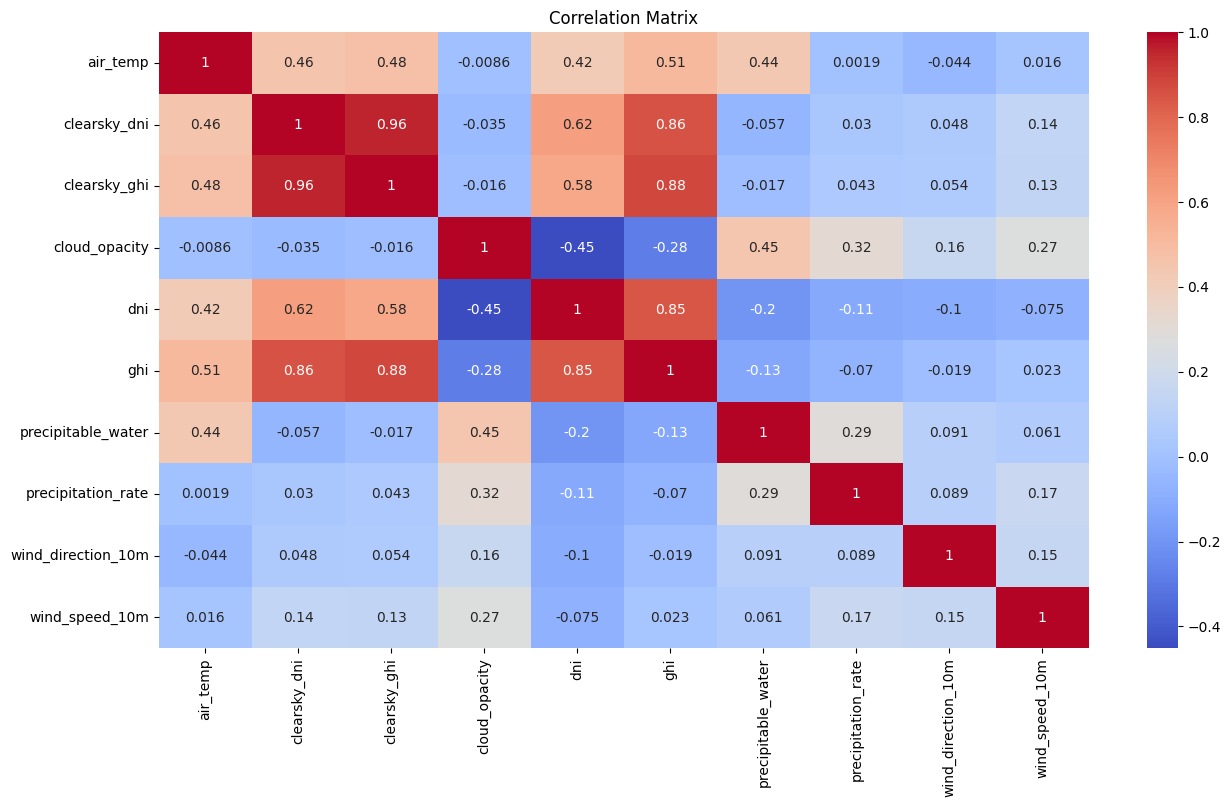

In [12]:
# Exclude date feature
numerical_df = df.select_dtypes(include=['float64', 'int64'])
numerical_df = numerical_df.drop(columns=['year', 'month', 'day', 'hour', 'minute'])
corr_matrix = numerical_df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

Main insights from the correlation matrix: 
1. GHI has 0.51 correlation with air_temp 
2. There is weak negative correlation between cloud_opacity and GHI (-0.28) 

### Next we will show some datra visualizations:
- Avg GHI 24h distribution per hour per year (kWh/m^2) 
- Avg GHI per day per year (kWh/m^2)
- air_temp 24h distribution
- cloud_opacity 24h distribution
- wind direction + speed patterns 
- cloud_opacity vs GHI 24h distribution
- clearsky vs actual radiation per year
- air_temp vs GHI per year
- percipitation rate vs percitipation water avg distribution per year

**(kWh = (watts × hrs) ÷ 1,000)**

In [13]:
def calculate_hourly_avg_ghi_per_year(df, year):
    df_year = df[df['year'] == year]
    ghi_avg = df_year.groupby(['hour'])['ghi'].mean().reset_index()
    return ghi_avg

In [14]:
def plot_hourly_avg_ghi_per_year(ghi_avg, year, ax, y_limits):
    # Plotting the bar chart on the specific axis (ax)
    sns.barplot(data=ghi_avg, x='hour', y='ghi', color='lightblue', edgecolor='black', ax=ax)

    # Overlaying a line plot to show the trend
    ax.plot(ghi_avg['hour'], ghi_avg['ghi'], color='darkblue', marker='o', linestyle='-', linewidth=2, markersize=6)

    # Adding title and labels
    ax.set_title(f'Hourly Average GHI in {year}', fontsize=14)
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('GHI (kWh/m²)', fontsize=12)

    # Adding gridlines for better visual separation
    ax.grid(True, linestyle='--')

    # Customizing x-ticks to show hours in "HH:MM" format (e.g., "00:00", "01:00")
    xticks = pd.date_range('00:00', '23:00', freq='h').strftime('%H:%M')
    ax.set_xticks(range(24))
    ax.set_xticklabels(xticks, fontsize=8, rotation=45)

    # Setting the same Y-axis scale for all subplots
    ax.set_ylim(y_limits)

In [15]:
def plot_all_years(df, start_year=2015, end_year=2024):
    # Create a 5x2 grid of subplots for years 2015 to 2024
    fig, axes = plt.subplots(5, 2, figsize=(20, 20))  # 5 rows, 2 columns
    axes = axes.flatten()  # Flatten to easily index the axes

    # Determine the global Y-axis limits across all years
    global_min = float('inf')
    global_max = float('-inf')

    for year in range(start_year, end_year + 1):
        ghi_avg = calculate_hourly_avg_ghi_per_year(df, year)
        global_min = min(global_min, ghi_avg['ghi'].min())
        global_max = max(global_max, ghi_avg['ghi'].max()+0.05)

    y_limits = (global_min, global_max)

    for i, year in enumerate(range(start_year, end_year + 1)):
        # Calculate the hourly average for each year
        ghi_avg = calculate_hourly_avg_ghi_per_year(df, year)
        # Plot the hourly average GHI for the specific year on the subplot
        plot_hourly_avg_ghi_per_year(ghi_avg, year, axes[i], y_limits)

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.show()

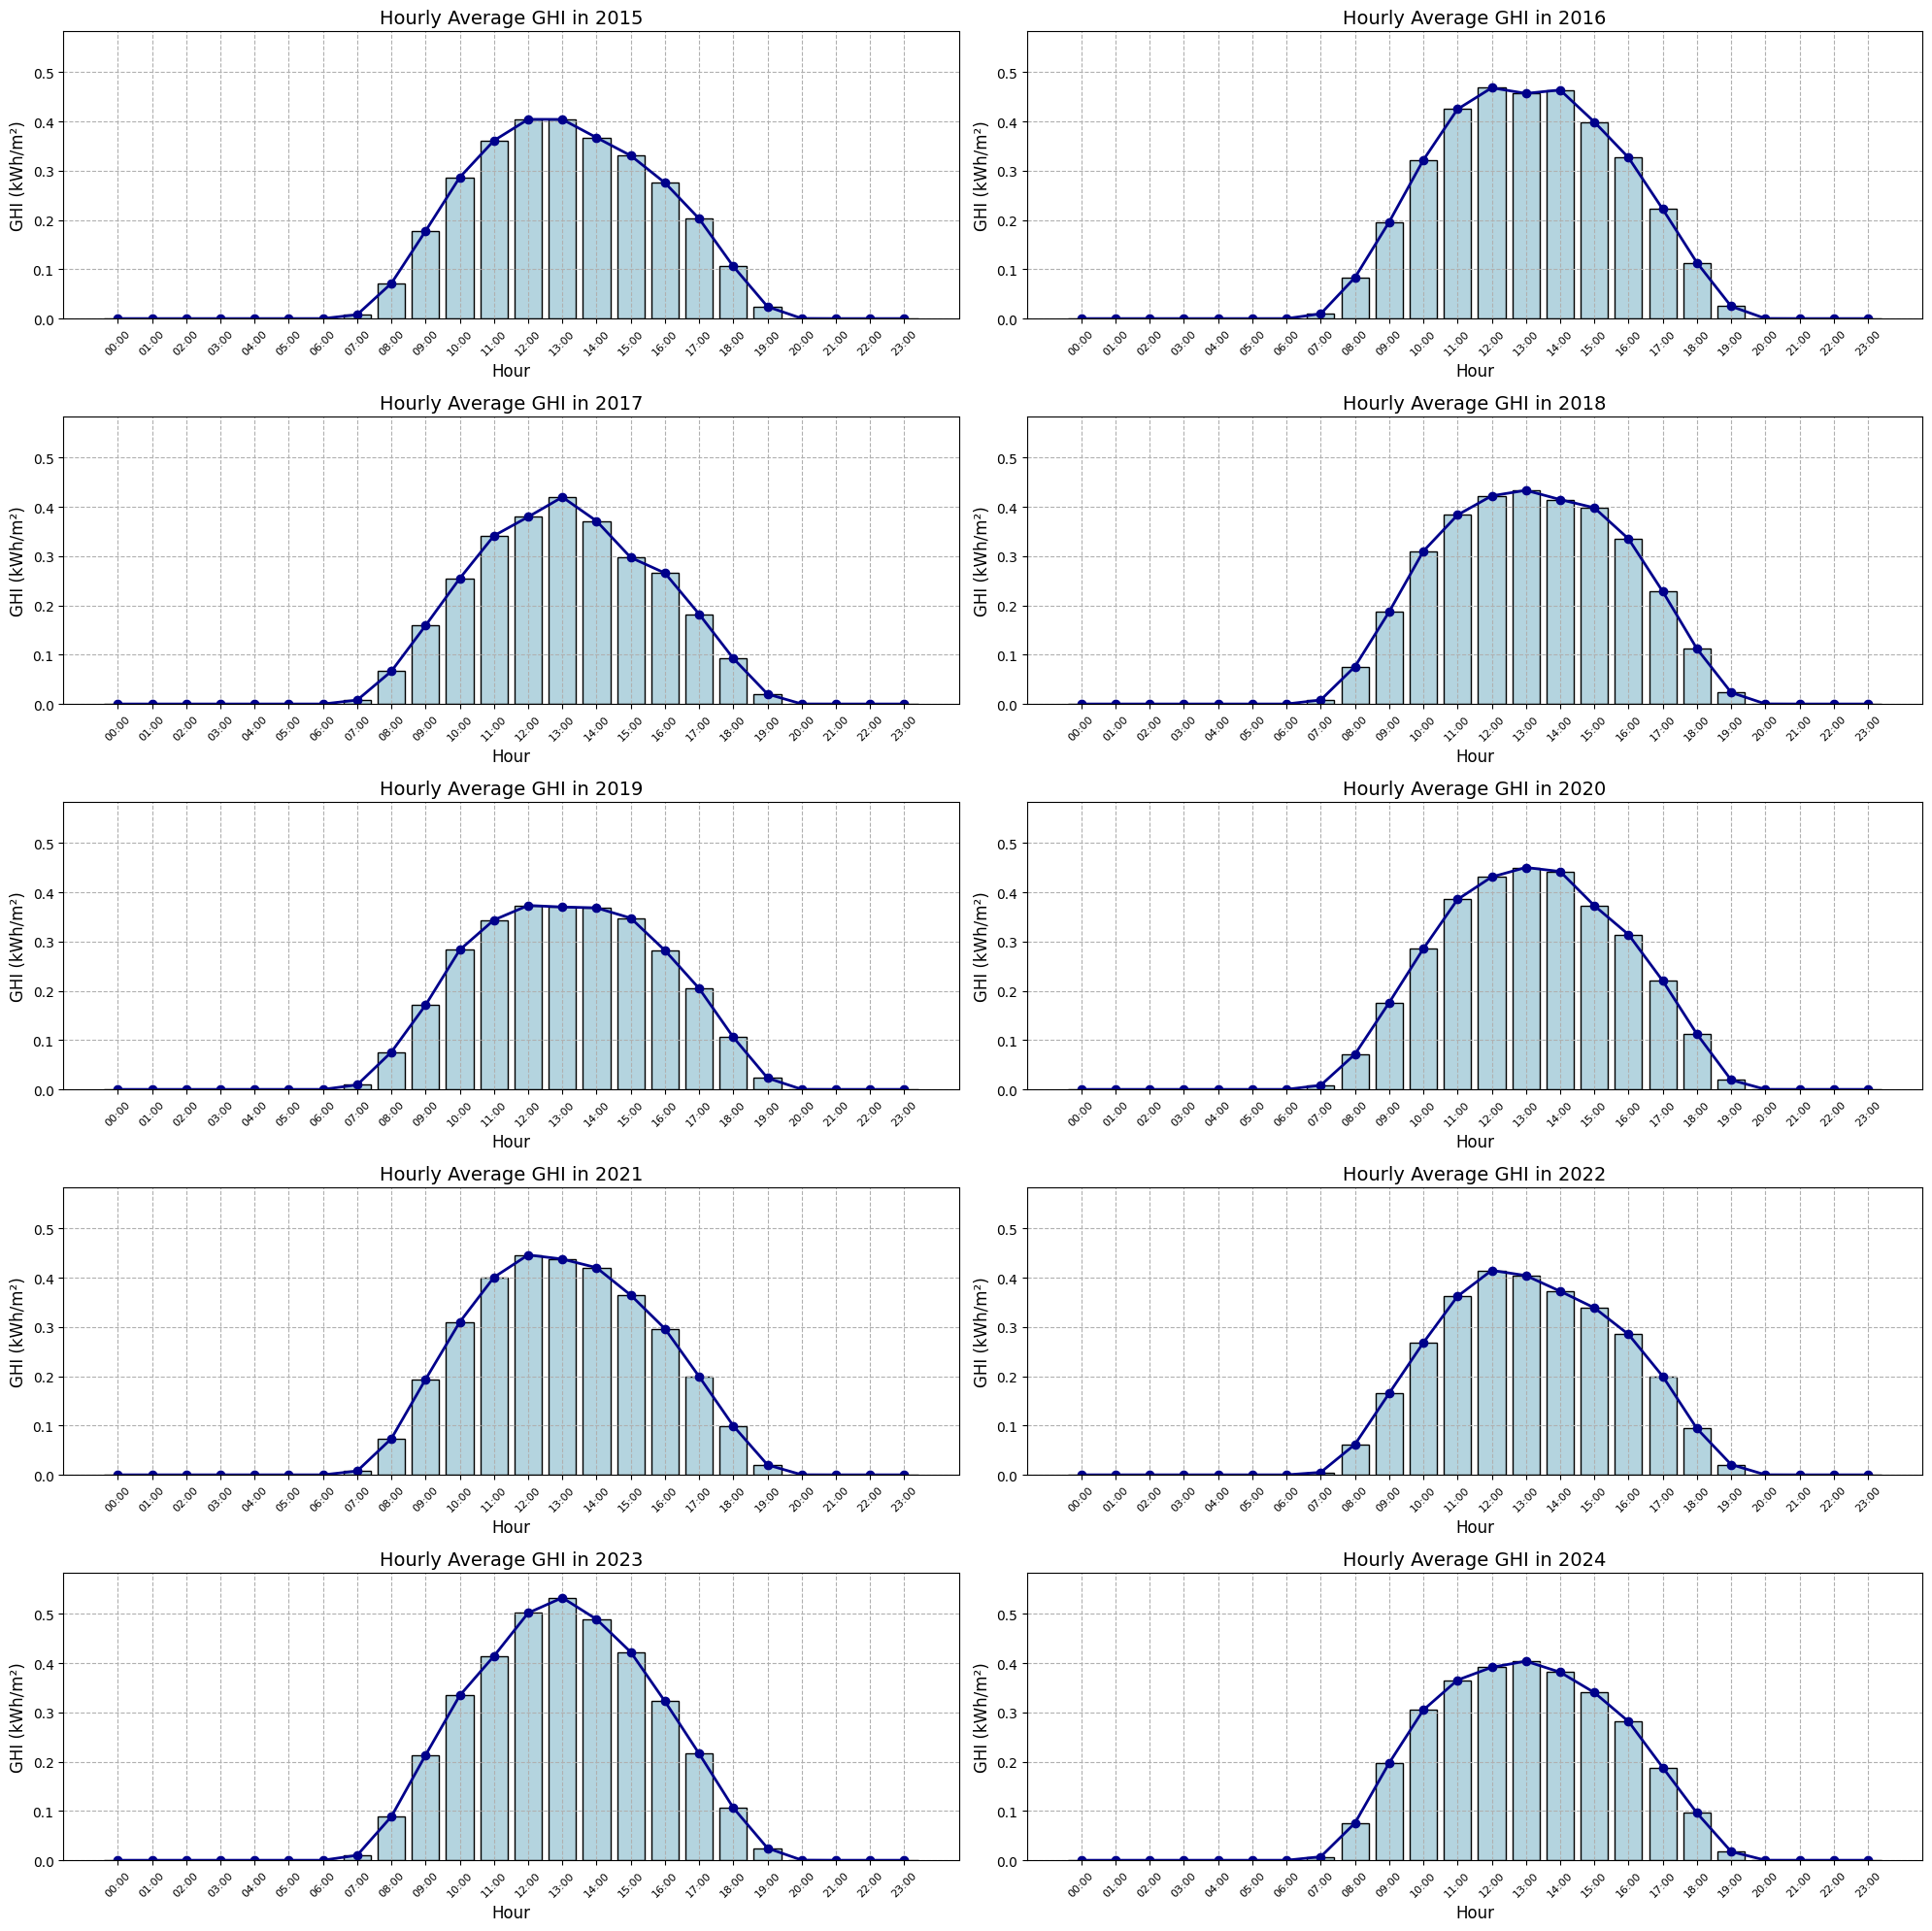

In [16]:
plot_all_years(df)

In [24]:
def plot_hourly_ghi_distribution(df):
    # Convert 'hour' column to a categorical variable for proper ordering
    df['hour'] = df['hour'].astype('category')

    # Create the Plotly box plot
    fig = px.box(
        df,
        x='hour',
        y='ghi',
        title='Hourly GHI Distribution 2014-2024',
        labels={'hour': 'Hour', 'ghi': 'GHI (kWh/m²)'}
    )

    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Hour',
        yaxis_title='GHI (kWh/m²)',
        title_font_size=16,
        xaxis=dict(tickmode='linear'),
        yaxis=dict(gridcolor='lightgray'),
        plot_bgcolor='white',
    )

    # Show the figure
    fig.show()

In [25]:
plot_hourly_ghi_distribution(df)

In [19]:
# next, ill calculate the mean ghi per day per year
def calculate_daily_avg_ghi_per_year(df, year):
    df_year = df[df['year'] == year]
    ghi_year_avg = df_year.groupby(['month', 'day'])['ghi'].mean().reset_index()
    # change kwh/m^2 to be kwh/m^2/day
    ghi_year_avg['ghi'] = ghi_year_avg['ghi'] * 24
    return ghi_year_avg

In [20]:
def plot_daily_avg_ghi_per_year(ghi_avg, year, ax, y_limits):
    # Plotting the bar chart on the specific axis (ax)
    sns.barplot(data=ghi_avg, x=ghi_avg['day'], y='ghi', color='lightblue', edgecolor='black', ax=ax)

    # Adding title and labels
    ax.set_title(f'Daily Average GHI in {year}', fontsize=14)
    ax.set_xlabel('Day (september-october)', fontsize=12)
    ax.set_ylabel('GHI (kWh/m²)', fontsize=12)

    # Adding gridlines for better visual separation
    ax.grid(True, linestyle='--')

    # Customizing x-ticks to show each day from `ghi_avg`
    ax.set_xticks(range(len(ghi_avg['day'])))
    ax.set_xticklabels(ghi_avg['day'].astype(str), fontsize=10)

    # Setting the same Y-axis scale for all subplots
    ax.set_ylim(y_limits)

In [21]:
def plot_all_years_daily(df, start_year=2015, end_year=2024):
    # Create a 5x2 grid of subplots for years 2015 to 2024
    fig, axes = plt.subplots(5, 2, figsize=(20, 20))  # 5 rows, 2 columns
    axes = axes.flatten()  # Flatten to easily index the axes

    # Determine the global Y-axis limits across all years
    global_min = float('inf')
    global_max = float('-inf')

    for year in range(start_year, end_year + 1):
        ghi_avg = calculate_daily_avg_ghi_per_year(df, year)
        global_min = min(global_min, ghi_avg['ghi'].min())
        global_max = max(global_max, ghi_avg['ghi'].max() + 0.05)

    y_limits = (global_min, global_max)

    for i, year in enumerate(range(start_year, end_year + 1)):
        # Calculate the hourly average for each year
        ghi_avg = calculate_daily_avg_ghi_per_year(df, year)
        # Plot the hourly average GHI for the specific year on the subplot
        plot_daily_avg_ghi_per_year(ghi_avg, year, axes[i], y_limits)

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.show()

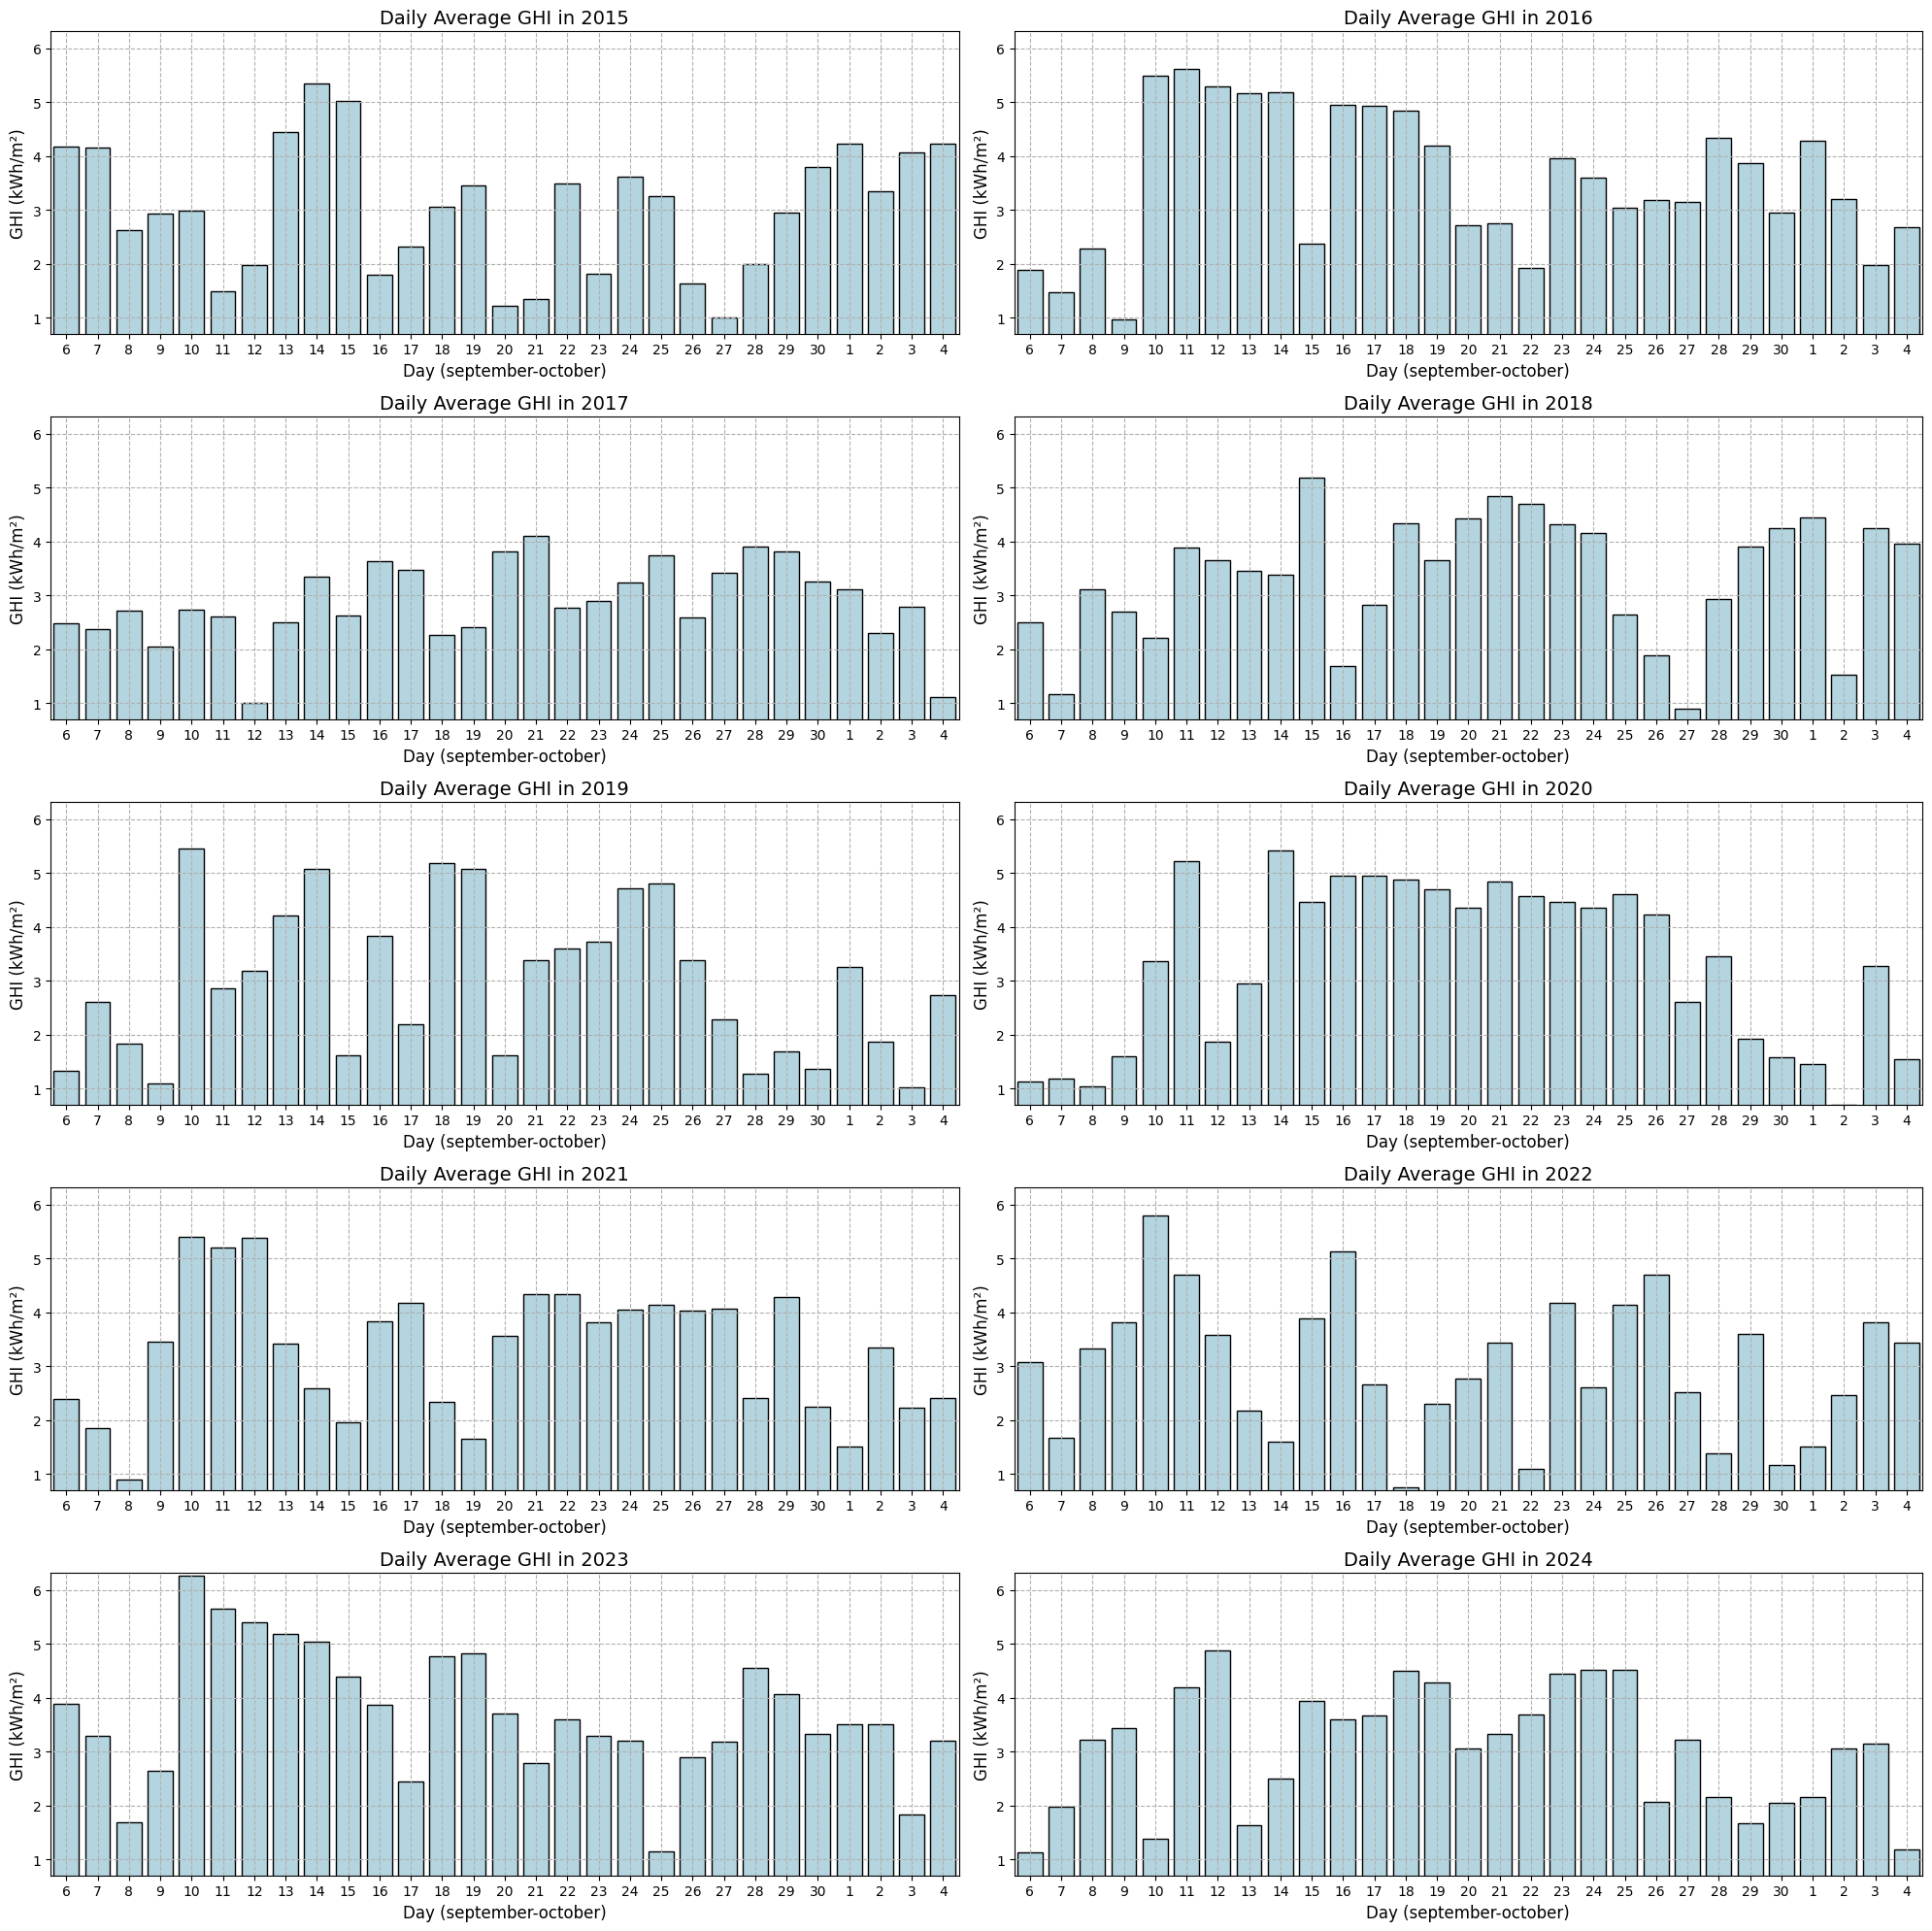

In [22]:
plot_all_years_daily(df)

In [37]:
def calculate_daily_avg_ghi(df):
    ghi_avg = df.groupby(['year', 'month', 'day'])['ghi'].mean().reset_index()
    # change kwh/m^2 to be kwh/m^2/day
    ghi_avg['ghi'] = ghi_avg['ghi'] * 24
    return ghi_avg

In [42]:
def plot_all_years_daily_avg_ghi(df):
    ghi_avg = calculate_daily_avg_ghi(df)
    fig = px.box(
        ghi_avg,
        x='year',
        y='ghi',
        title='Daily Average GHI Distribution 2014-2024',
        labels={'year': 'Year', 'ghi': 'GHI (kWh/m²)'}
    )
    
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='GHI (kWh/m²)',
        title_font_size=16,
        xaxis=dict(tickmode='linear'),
        yaxis=dict(gridcolor='lightgray'),
        plot_bgcolor='white',
    )

    fig.show()

In [43]:
plot_all_years_daily_avg_ghi(df)